# Making my own model for RR

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.animation import FuncAnimation
import glob
import numpy as np
import sys, os
import netCDF4 as nc
import xarray as xr
from IPython import display
from numpy import loadtxt
from tqdm.notebook import trange, tqdm
from time import sleep
from scipy import optimize
from scipy.stats import norm
import pandas as pd

from mpl_toolkits.basemap import Basemap
from pyresample import kd_tree,geometry
from pyresample import load_area, save_quicklook, SwathDefinition

In [2]:
directory = '../RR_OIB/'
files = glob.glob(directory + '*.text')

RR_list = np.array([0,1,6,4,29,50,51,54,55,56,57,60,61,62,63])

count = 0
RR =  []
prnt = False

for p in range(len(files)):
    
    with open(files[p], 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]
        header = all_data[1].split(',')
        data = all_data[2:]
    
        Data = np.zeros((len(data),len(header)))
    
        for i in range(len(data)):
        
            d = data[i].split(',')
        
            for j in range(np.size(Data[0])):
            
                try:
                    Data[i,j] = d[j]
                except:
                    pass

            #for i in range(len(header)):
            if Data[i,RR_list].all():
                count += 1

                #useful[i,:] = Data[i,[0,1,6,4,29,84,95,85,96,61,56]]
                
                try:
                    RR = np.concatenate((RR,np.array([Data[i,RR_list]])))
                except:
                    RR = np.array([Data[i,RR_list]])
                                    
                if prnt:
                    print('File number:',p,',',i)
                    for k in np.array(RR_list):
                        print('')
                        print(header[k])
                        print(Data[i,k])
                    print('\n')

In [3]:
np.min(RR[:,12])

180.1

In [4]:
GR = (RR[:,12]-RR[:,10]) / (RR[:,12]+RR[:,10]) # bruger den fra nasa websiten
print(GR)

[-0.05277478 -0.04012528 -0.04023557 ... -0.06305044 -0.05642691
 -0.04475039]


In [5]:
Type = np.ones(len(GR))

Type[GR >= -0.05] = 0 # 0 er first year ice
Type

GR = Type


In [6]:
alpha = np.empty([10,5])

i_t  = RR[:,2]
s_t = RR[:,3]
Tem   = RR[:,4]

eq = np.array([i_t,s_t,Tem,GR,np.ones(len(GR))]).T

for i in range(10):
    a = np.linalg.lstsq(eq, RR[:,i+5], rcond=None)[0]

    alpha[i] = a
    
np.round(alpha)

array([[ -1.,  -0.,  -0.,   0., 249.],
       [ -1.,  -6.,   0.,   1., 225.],
       [ -2., -13.,  -0.,  -1., 253.],
       [ -2., -15.,   0.,   0., 225.],
       [ -3., -32.,   0.,  -6., 237.],
       [ -4., -31.,   0.,  -5., 203.],
       [ -5., -53.,   0., -14., 171.],
       [ -5., -49.,   1., -15., 108.],
       [ -2., -37.,   1.,  -8., -37.],
       [ -2., -36.,   1.,  -8., -84.]])

In [7]:
ind = 0
iceDepth = RR[:,2]
snowDepth = RR[:,3]
Temperature = RR[:,4]
Type = GR[:]


var = np.stack([iceDepth,snowDepth,Temperature,Type,np.ones(len(Type))])



Tb = np.dot(alpha,var).T


#Tb = np.sum(alpha * var, axis = 1)

print(np.shape(Tb))
    
Tbv = Tb[:,1::2]
Tbh = Tb[:,::2]

#V = RR[:,[6,8,10,12,14]]
#H = RR[:,[5,7,9,11,13]]
print(np.round(var[:,23],1))
print(alpha[9])

(1511, 10)
[  2.7   0.4 244.    0.    1. ]
[ -1.81824752 -36.15586236   1.22696515  -7.56671411 -83.65095106]


In [8]:
# 0, 0 
0.3*-0.58+1.9*-21.29+249*-0.66+1*-0.37+1*397.5

192.165

In [9]:
# var 0, alpha 1
0.3*-0.8 + 5.4*-29.8 + 246.9*-.16 + 1*-7.22 + 1*254

46.11599999999996

In [10]:
np.sum(alpha[9]*var[:,23])

196.98869345925135

In [11]:
np.dot(alpha[9],var[:,23]).T

196.98869345925135

In [12]:
RR[23,[5,7,9,11,13]]


array([224.01, 220.77, 210.94, 192.08, 183.75])

In [13]:
bob = np.arange(0,10)
bob[::2]

array([0, 2, 4, 6, 8])

In [14]:
print(Tbh[1])
print(RR[1,[6,8,10,12,14]])

[227.56724689 227.03891128 221.09423729 207.23682055 190.34416167]
[242.47 238.45 229.15 211.47 191.51]


In [112]:
def RRtp(IceDepth,snowDepth,Temperature,Type):

    var = np.array([iceDepth,snowDepth,Temperature,Type,np.ones(len(Type))])
    
    #Tb = np.sum(alpha * var, axis = 1)
    Tb = np.dot(alpha,var).T

    
    print(np.shape(Tb))
    
    Tbv = Tb[:,1::2]
    Tbh = Tb[:,::2]
    return Tbv, Tbh

In [113]:
def meanDiff(TbV,TbH):
    
    BT_V = TbV - RR[:,[6,8,10,12,14]]
    BT_H = TbH - RR[:,[5,7,9,11,13]]
    
    V_avg = BT_V.mean(0)
    H_avg = BT_H.mean(0)

    score = (V_avg.mean()+H_avg.mean())/2
    
    return score,BT_V,BT_H

In [114]:
Tbv, Tbh = RRtp(RR[:,2],RR[:,3],RR[:,4],GR)

score,BT_V,BT_H = meanDiff(Tbv,Tbh)
print(np.mean(BT_V),np.mean(BT_H))
print(score)

(1511, 10)
1.1264853304884416e-12 7.823550469867027e-13
9.54412664790668e-13


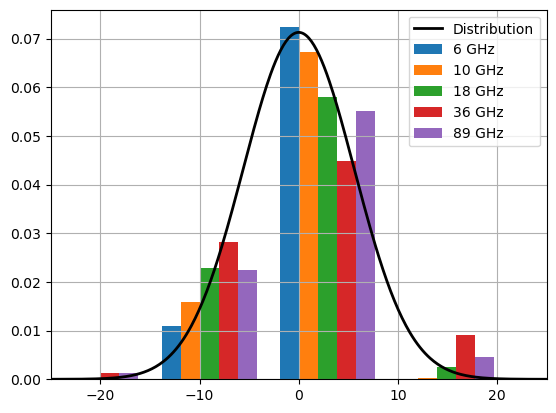

In [115]:
bins = 20

mu, sigma = norm.fit(BT_V)

n, bins, patches = plt.hist(BT_V,density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1001)
p = norm.pdf(x, mu, sigma)

plt.plot(x, p, 'k', linewidth=2)
plt.grid()
plt.legend(['Distribution','6 GHz','10 GHz','18 GHz','36 GHz','89 GHz'])
plt.xlim([-25,25])
plt.show()

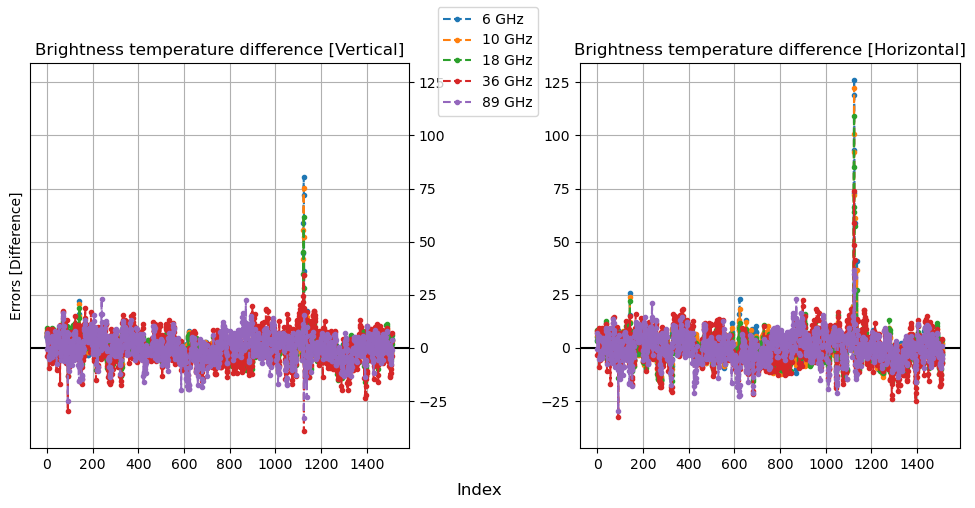

In [116]:
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(12,5),sharey = True)
plt.subplot(121)
plt.axhline(c = 'k')
plt.plot(BT_V,'.--')
plt.title('Brightness temperature difference [Vertical]')
plt.grid()
plt.tick_params('y',left = False,labelleft = False,right = True,labelright = True)
plt.ylabel('Errors [Difference]')

# Model udregnet - RR faktisk bt

plt.subplot(122)
plt.axhline(c = 'k')
plt.plot(BT_H,'.--',label=(['6 GHz','10 GHz','18 GHz','36 GHz','89 GHz']))
plt.title('Brightness temperature difference [Horizontal]')
plt.grid()
plt.tick_params('y',labelleft = True)

fig.legend(loc='upper center')
fig.supxlabel('Index')
fig.subplots_adjust(wspace=0.45)
plt.show()

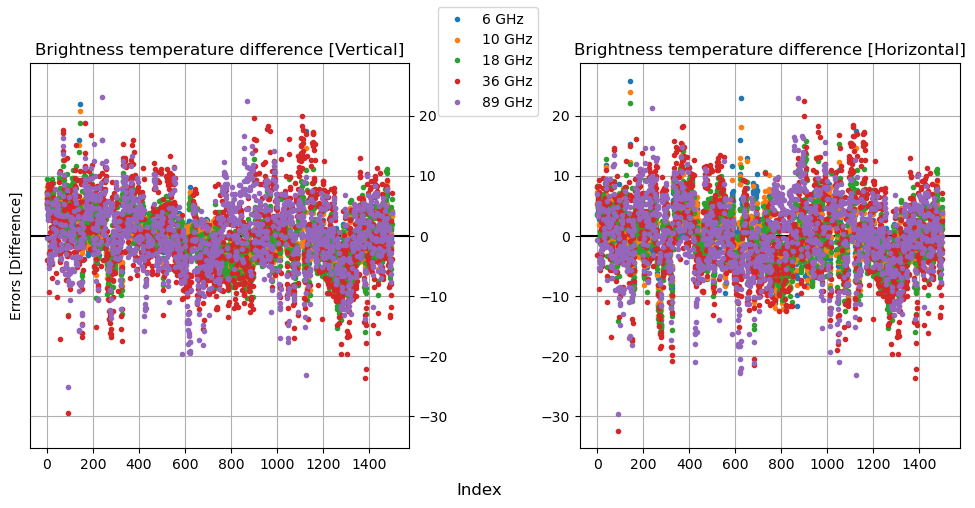

In [117]:
BT_H_new = np.concatenate([BT_H[:1120],BT_V[1130:]])
BT_V_new = np.concatenate([BT_V[:1120],BT_V[1130:]])

fig, (ax1,ax2)= plt.subplots(1,2,figsize=(12,5),sharey = True)
plt.subplot(121)
plt.axhline(c = 'k')
plt.plot(BT_V_new,'.')
plt.title('Brightness temperature difference [Vertical]')
plt.grid()
plt.tick_params('y',left = False,labelleft = False,right = True,labelright = True)
plt.ylabel('Errors [Difference]')

# Model udregnet - RR faktisk bt

plt.subplot(122)
plt.axhline(c = 'k')
plt.plot(BT_H_new,'.',label=(['6 GHz','10 GHz','18 GHz','36 GHz','89 GHz']))
plt.title('Brightness temperature difference [Horizontal]')
plt.grid()
plt.tick_params('y',labelleft = True)

fig.legend(loc='upper center')
fig.supxlabel('Index')
fig.subplots_adjust(wspace=0.45)
plt.show()

In [48]:
#tie-point model for ice and open water
def tiepoint(snedybde, istykkelse, overfladetemperatur, iskoncentration):
    #the mar+april 2013 model
    #Tb for sea ice
    #overfladetemperatur [K]
    #snedybde [m]
    #istykkelse [m]
    #iskoncentration [0-1]
    T6vsi = 151.981 + 0.398 * overfladetemperatur+ 23.360 * snedybde -3.031 * istykkelse
    T6hsi = 55.262 + 0.687 * overfladetemperatur+ 12.962 * snedybde -1.664 * istykkelse
    T10vsi = 145.878 + 0.435 * overfladetemperatur+ 0.743 * snedybde -4.202 * istykkelse
    T10hsi = 45.107 + 0.753 * overfladetemperatur -18.7322 * snedybde -3.490 * istykkelse
    T18vsi = 138.073 + 0.479 * overfladetemperatur -71.814 * snedybde -5.570 * istykkelse
    T18hsi = 78.424 + 0.641 * overfladetemperatur -85.184 * snedybde -5.341 * istykkelse
    T36vsi = 123.102 + 0.526 * overfladetemperatur -216.727 * snedybde -4.036 * istykkelse
    T36hsi = 131.862 + 0.429 * overfladetemperatur -214.352 * snedybde -3.035 * istykkelse
    T89vsi = 2.525 + 0.902 * overfladetemperatur -180.427 * snedybde+ 1.904 * istykkelse
    T89hsi = 31.120 + 0.743 * overfladetemperatur -184.806 * snedybde+ 3.197 * istykkelse
    #Tb for open water
    T6vow=161.35
    T6how=82.13
    T10vow=167.34
    T10how=88.26
    T18vow=183.72
    T18how=108.46
    T36vow=196.41
    T36how=128.23
    T89vow=243.20
    T89how=196.94
    #Tb for ice and open water
    T6vsim  = iskoncentration*T6vsi  + (1-iskoncentration)*T6vow
    T6hsim  = iskoncentration*T6hsi  + (1-iskoncentration)*T6how
    T10vsim = iskoncentration*T10vsi + (1-iskoncentration)*T10vow
    T10hsim = iskoncentration*T10hsi + (1-iskoncentration)*T10how
    T18vsim = iskoncentration*T18vsi + (1-iskoncentration)*T18vow
    T18hsim = iskoncentration*T18hsi + (1-iskoncentration)*T18how
    T36vsim = iskoncentration*T36vsi + (1-iskoncentration)*T36vow
    T36hsim = iskoncentration*T36hsi + (1-iskoncentration)*T36how    
    T89vsim = iskoncentration*T89vsi + (1-iskoncentration)*T89vow
    T89hsim = iskoncentration*T89hsi + (1-iskoncentration)*T89how    
        
    Tbv=np.array([T6vsim,T10vsim,T18vsim,T36vsim,T89vsim])
    Tbh=np.array([T6hsim,T10hsim,T18hsim,T36hsim,T89hsim])
    return Tbv, Tbh

In [49]:
directory = '../Data_NEW/'
files = glob.glob(directory + 'iceh.*.nc')

Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

freqs = np.array([7,10,18,37,89])
ice_type = 'firstyear'
iceConc = 1
jump = 1

V_tp,H_tp, V_RR,H_RR = [np.empty([len(files),len(freqs),888, 781]) for _ in range(4)]

In [89]:
def RRtp(IceDepth,snowDepth,Temperature,Type):

    var = np.array([iceDepth,snowDepth,Temperature,Type,1])
    
    #Tb = np.sum(alpha * var, axis = 1)
    Tb = np.dot(alpha,var).T

    
    print(np.shape(Tb))
    
    Tbv = Tb[1::2]
    Tbh = Tb[::2]
    return Tbv, Tbh

In [104]:
for month in trange(len(files)):
    
    ds = nc.Dataset(files[month])
    
    lat = ds.variables["TLAT"]
    lon = ds.variables["TLON"]
    Tinz = ds.variables["Tinz"][0,0]

    SnowThickness = ds.variables["hs"][0]
    IceThickness  = ds.variables["hi"][0]
    SurfaceTemp   = ds.variables["Tsfc"][0] + 273.15
    
    year = '2007'
    
    if month >= 4:
        year = '2008'
        
        if month >= 16:
            year = '2009'
    
    for y in trange(0,lat.shape[0],jump,desc= year + '-' + Months[(month+8)%12]):        
        for x in range(0,lat.shape[1],jump):
               
                if np.floor(SnowThickness[y,x]*100) > 0:
                    
                    if IceThickness[y,x] >= 1.5:
                        ice_type = 1

                    else:
                        ice_type = 0
                                                                                
                    V_tp_,H_tp_ = tiepoint(SnowThickness[y,x],IceThickness[y,x],SurfaceTemp[y,x],iceConc)
                    V_tp[month,:,y,x] = V_tp_
                    H_tp[month,:,y,x] = H_tp_
                    
                                                                                
                    V_RR_,H_RR_ = RRtp(IceThickness[y,x],SnowThickness[y,x],SurfaceTemp[y,x],iceConc)
                    V_RR[month,:,y,x] = V_RR_
                    H_RR[month,:,y,x] = H_RR_
                    

  0%|          | 0/24 [00:00<?, ?it/s]

2007-September:   0%|          | 0/888 [00:00<?, ?it/s]

(10,)


C:\Users\fnifd\AppData\Local\Temp\ipykernel_7264\1565820267.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var = np.array([iceDepth,snowDepth,Temperature,Type,1])


ValueError: setting an array element with a sequence.

In [91]:
V_RR_,H_RR_ = RRtp(IceThickness[y,x],SnowThickness[y,x],SurfaceTemp[y,x],iceConc)


(10,)


C:\Users\fnifd\AppData\Local\Temp\ipykernel_7264\1565820267.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  var = np.array([iceDepth,snowDepth,Temperature,Type,1])


In [94]:
np.shape(iceDepth)


(1511,)

In [111]:
ds = nc.Dataset(files[month])
    
lat = ds.variables["TLAT"]
lon = ds.variables["TLON"]
Tinz = ds.variables["Tinz"][0,0]

SnowThickness = ds.variables["hs"][0]
IceThickness  = ds.variables["hi"][0]
SurfaceTemp   = ds.variables["Tsfc"][0] + 273.15


var = np.array([IceThickness[310,310],SnowThickness[310,310],SurfaceTemp[310,310],1,1])
    
#Tb = np.sum(alpha * var, axis = 1)
Tb = np.dot(alpha,var).T

    
print(np.shape(Tb))
    
Tbv = Tb[1::2]
Tbh = Tb[::2]
print(Tb)

(10,)
[229.15639462 257.86501188 233.49425192 259.96998612 233.52383152
 258.53927117 226.98946084 247.52895607 226.58832081 241.71933609]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob
import numpy as np
import sys, os
import netCDF4 as nc
import xarray as xr
from IPython import display

from mpl_toolkits.basemap import Basemap
from pyresample import kd_tree,geometry
from pyresample import load_area, save_quicklook, SwathDefinition

fig = plt.figure(figsize=(10,8))
a = 1
names = ['smrt V','Tiepoint V','smrtH','TbH']
datas = [smrtV[a,0,:,:],TbV[a,0,:,:],smrtH[a,0,:,:],TbH[a,0,:,:]]

#fig, axs = plt.subplots(2, 2)

for i in range(len(names)):
    d = datas[i]

    testData = np.ma.array(d, mask = d < .2)
    testLats = np.ma.array(lat, mask = d < .2)
    testLons = np.ma.array(lon, mask = d < .2)

    #axs[round(i/2.1),i%2].set_title(names[i])
    #axes[0,].set_title("Hammer projection")
    plt.subplot(221+i)
    plt.title(names[i])
    
    #m = Basemap(projection='npstere',boundinglat=60.0,lon_0=360.0,resolution='c',area_thresh=50000,ax=axs[round(i/2.1),i%2])
    m = Basemap(projection='npstere',boundinglat=60.0,lon_0=360.0,resolution='c',area_thresh=50000)
    m.drawparallels(range(0, 180, 10))
    m.drawmeridians(range(0, 360, 20))
    m.drawcoastlines(linewidth=0.15)
 
    # add temperature data as scatter-plot on map
    x,y = m(testLons,testLats)
    m.scatter(x,y,c=testData,vmin=190, vmax=265,cmap=plt.cm.jet,edgecolors=None,s=0.15)

    
# add plot title, colorbar
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.82, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()